In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin/BTC.xlsx


# About Prophet

Prophet is an open-source tool developed by the data science team at Facebook (currently Meta) back in 2017. It has many advantages. It doesn't demand a lot of data cleaning since it handles missing values and outliers automatically. Plus, it is easy to fit and highly flexible.

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import The Data 

In [3]:
df= pd.read_excel('/kaggle/input/bitcoin/BTC.xlsx')
df.head()

,Date,Price
0,2023-01-01,16618.4
1,2023-01-02,16674.3
2,2023-01-03,16674.2
3,2023-01-04,16852.1
4,2023-01-05,16829.8


The dataset represents Bitcoin prices over the past three years (from January 1, 2023, to April 19, 2025), and it is obtained from Yahoo Finance.

# Rename Columns 

It is important before building a prophet model, to rename both the date column and the price column to 'ds' and 'y', respectively.

In [4]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2023-01-01,16618.4
1,2023-01-02,16674.3
2,2023-01-03,16674.2
3,2023-01-04,16852.1
4,2023-01-05,16829.8


# Descriptive Analysis

## Line Chart

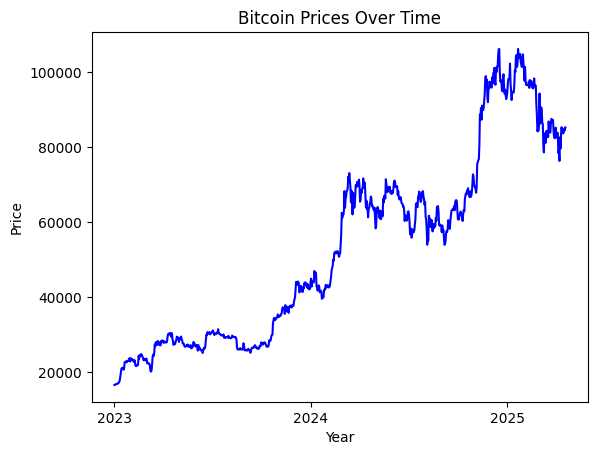

In [5]:
import matplotlib.dates as mdates
#Ensure x axis is in years
df['Year']= df['ds'].dt.year
sns.lineplot(data=df, x='ds', y= 'y', color= 'blue')
plt.title('Bitcoin Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()



The line chart shows that the time series is quite volatile, due to several reasons. Some of these are technical, such as the calls for green mining in 2022, and political, including Donald Trump's presidency and his pro-bitcoin statements. 

## Box Plot

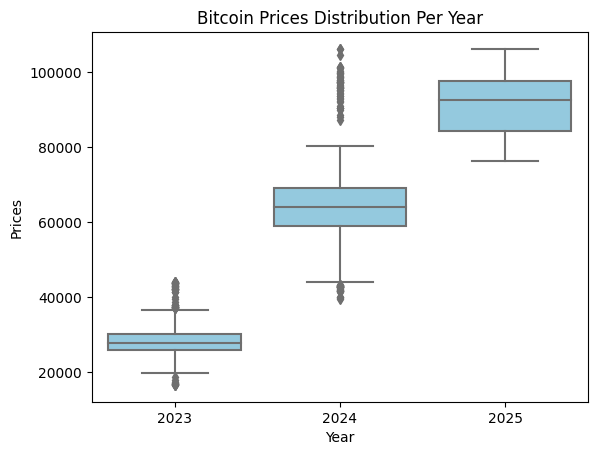

In [6]:
#make sure the x-axis is in years
df['Year']= df['ds'].dt.year
#Box Plot
sns.boxplot(data=df, x='Year', y='y', color='skyblue')
plt.title('Bitcoin Prices Distribution Per Year')
plt.xlabel('Year')
plt.ylabel('Prices')
plt.show()

The Box Plot confirms the substantial variance of prices over the years, with remarkable peaks and throughs identified as outliers (Black dots), especially in the years 2023 and 2024.

## ACF & PACF

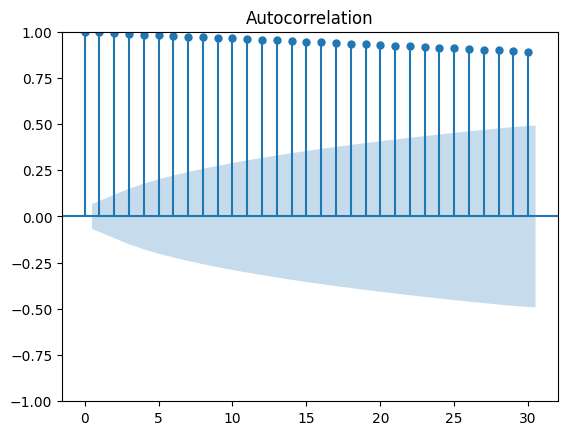

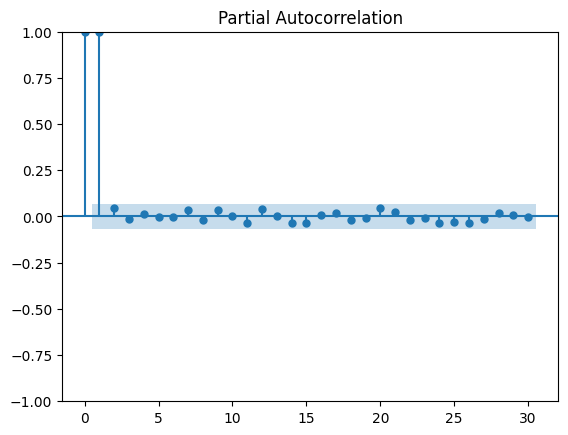

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plot acf and pacf
plot_acf(df['y'])
plot_pacf(df['y'])
plt.show()

The Autocorrelation Function (ACF) shows an upward trend in the prices. However, the Partial Autocorrelation Function (PACF) indicates that most correlations are insignificant (the blue dots are within the blue shaded area or confidence interval 95%). Therefore, it can be concluded that bitcoin prices in the past do not strongly determine future prices, highlighting the stochastic nature of the series.

# Install Prophet Library

In [8]:
#install prophet library
!pip install prophet

# Building The Model

10:03:42 - cmdstanpy - INFO - Chain [1] start processing
10:03:42 - cmdstanpy - INFO - Chain [1] done processing


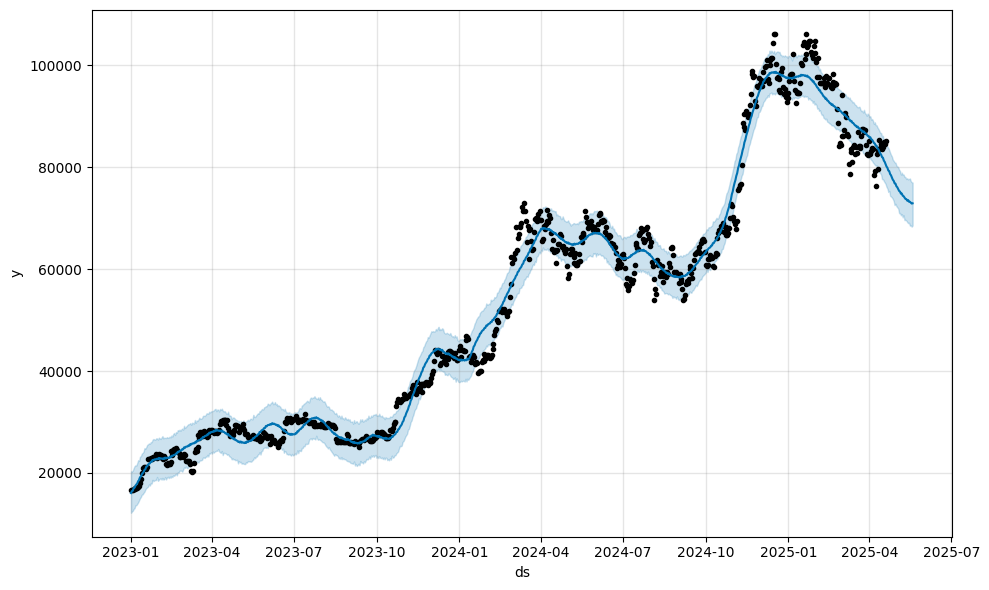

In [9]:
from prophet import Prophet
#ensure ds is in a date format
df['ds']= pd.to_datetime(df['ds'])
#intialize the model
model= Prophet()
#fit the model 
model.fit(df)
#create a future data frame
future= model.make_future_dataframe(periods= 30)
#make forecasts
forecast= model.predict(future)
#plot forecast
model.plot(forecast)
plt.show()

After fitting the model, we can see that the predicted prices (black dots) are very close to the real ones (blue line), which shows a remarkably high accuracy in forecasting the prices using Prophet.

# Prophet Components

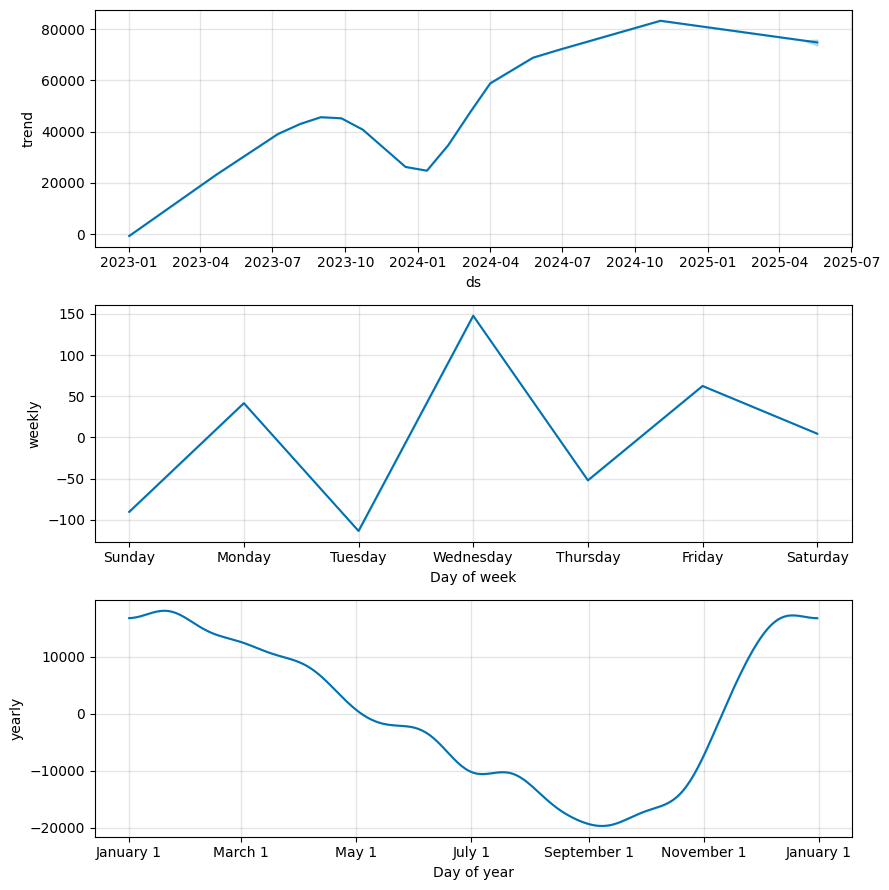

In [10]:
#Prophet Components
model.plot_components(forecast)
plt.show()


Prophet's components help analyze the different patterns in the time series (daily, weekly...). Looking at the trend graph, it's clear that prices are generally increasing in the next few months, with a slight decrease by the start of 2025. Based on the weekly seasonality, Wednesdays seem to be the days when the prices rise the most, potentially thanks to the information gathered during the week, leading to more informed trading decisions. In terms of the yearly patterns,  prices tend to decline during summer holidays till September, when they begin to pick up again.

In [11]:
#print forecasts with expected price range (min and max bounds) 
forecast[['ds','yhat','yhat_upper','yhat_lower']].tail()

,ds,yhat,yhat_upper,yhat_lower
865,2025-05-15,73227.215586,77696.212482,69090.082628
866,2025-05-16,73224.161447,77796.592923,68524.324277
867,2025-05-17,73059.287513,77260.988504,68576.475448
868,2025-05-18,72867.322931,77057.732352,68321.813961
869,2025-05-19,72911.446536,76988.818523,68564.076370


One of the advantages Prophet offers is that it not only predicts prices (yhat) but also predicts the potential range of price fluctuations (yhat_upper and yhat_lower).

# Prophet Dynamic Chart

In [14]:
from prophet.plot import plot_plotly
fig= plot_plotly(model, forecast)
fig.update_layout(title= 'Dynamic Forecast Chart')
fig.show()

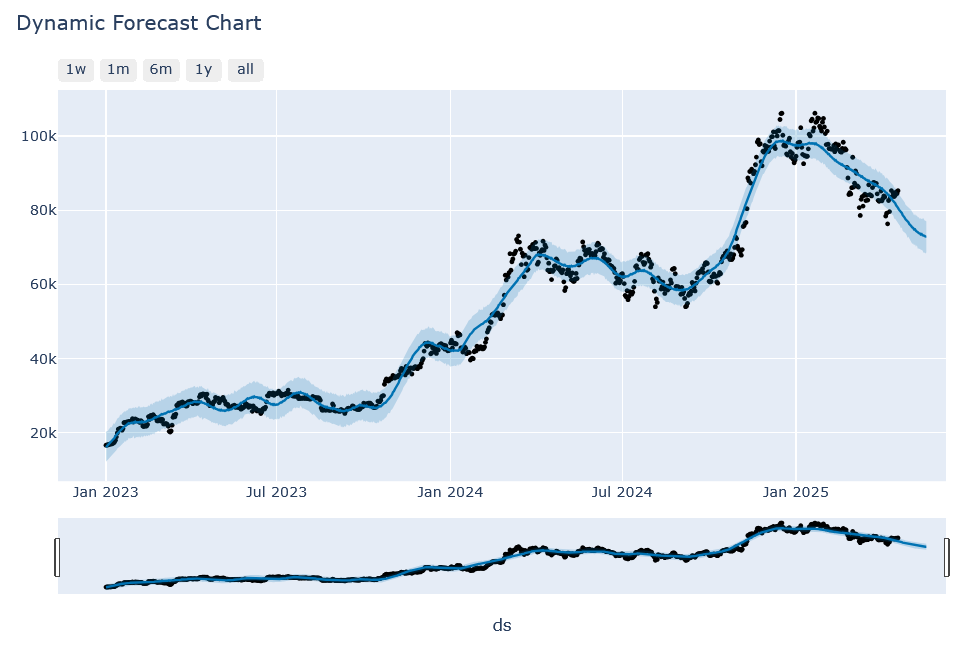

The Prophet library includes an interactive chart that makes it easier to explore the forecasts. You can zoom in and out using the slider below the chart to focus on specific timeframes, and the icons above allow you to quickly select viewing periods, such as 1 week, 1 month, 6 months, 1 year, or all.

# Evaluation Metrics

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results= df.merge(forecast[['ds','yhat']],on='ds')
y_true= results['y']
y_pred= results['yhat']
mae= mean_absolute_error(y_true, y_pred)
mse= mean_squared_error(y_true, y_pred)
rmse= np.sqrt(mse)
mape= np.mean(np.abs((y_true - y_pred)/y_pred))*100
r2= r2_score(y_true, y_pred)
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.4f}')
print(f'MAPE: {mape:.2f}%')


MSE: 10089369.89
MAE: 2403.02
R²: 0.9841
MAPE: 4.75%


In general, the error metrics are notably low, except for R², which indicates a significant correlation between actual and predicted prices. However, it is worth noting that when working with 5 years of data, it was observed that Prophet predicted a rise in prices with estimations around 100,000 USD, which was the price range in reality when Bitcoin hit 100,000 USD and surpassed it later for the first time since its creation.